# Titanic: Machine Learning from Disaster
Start here! Predict survival on the Titanic and get familiar with ML basics

A rede definida usa como entrada as seguintes colunas disponibilizadas pelo Kaggle:
- pclas;
- sex;
- sibsp;
- parch;

Durante o tratamento dos dados foi criada uma nova entrada, 'title', retirada do nome do passageiro.
Esta rede foi a que mostrou melhor resultado nos testes realizados.

Testes que resultaram em um desempenho pior:
- uso de regularização l1 nas camadas intermediárias;
- uso de regularização l2 nas camadas intermediárias;
- primeira camada intermediária com mais neurônios ou menos neurônios;
- segunda camada intermediárias com menos neurônios;
- tentativa de prever as idades em falta usando uma outra rede neural;
- tentativa de usar a média das idades nas idades em falta;
- tentativa de usar a coluna com o número da cabine, associando um valor aleatório às cabines em falta;
- tantativa de usar o porto de embarque, associando um valor aleatório aos portos em falta;

Obs. O código do cálculo da média das idades e a rede neural para previsão das idades foi deixado no notebook mas não são usados. Em caso de execução deste notebook, pular da sessão '2 - Pré-processamento dos dados' para a sessão '3 - Divisão dos dados em treinamento e validação' para obter o resultado submetido.

In [1]:
import numpy as np
import sys
import pandas as pd

import keras
import keras.regularizers as reg
from keras.utils import np_utils 
from keras.layers import Input, Embedding, concatenate
from keras.models import Model, Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.optimizers import Adam, RMSprop

from sklearn.preprocessing import LabelEncoder

sys.path.append('../src')
from my_keras_utilities import (train_network,
                                test_network,
                                TrainingPlotter,
                                )

# evita falso positivo SettingWithCopyWarning
pd.options.mode.chained_assignment = None 

Using TensorFlow backend.


## 1 - Leitura dos dados

### Data Dictionary

| Variable | Definition | Key |
|----------|------------|-----|
| survival | Survival   | 0 = No, 1 = Yes |
| pclass   | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
| sex      | Sex        |	|
| age      | Age in years | |	
| sibsp    | # of siblings / spouses aboard the Titanic	| |
| parch	   | # of parents / children aboard the Titanic | |
| ticket   | Ticket number | |
| fare     | Passenger fare	| |
| cabin    | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [2]:
raw_trn_data = pd.read_csv('/etc/jupyterhub/ia368z_2s2017/datasets/titanic/train.csv')
raw_tst_data = pd.read_csv('/etc/jupyterhub/ia368z_2s2017/datasets/titanic/test.csv')

In [3]:
# concatena os dados de teste e treinamento em uma única entrada
raw_trn_data['is_test'] = 0
raw_tst_data['is_test'] = 1
raw_all_data = pd.concat((raw_trn_data, raw_tst_data), axis=0)

## 2 - Pré-processamento dos dados

In [4]:
# cria nova coluna com o título das pessoas
def get_titles_from_names(df):
    names = df['Name'].str.split(', ', n=0, expand=True)
    titles = names[1].str.split('.', n=0, expand=True)
    df['Title'] = titles[0]
    # transforma os títulos em valores numéricos
    encoder = LabelEncoder()
    encoder.fit(df['Title'])
    df['Title'] = encoder.transform(df['Title'])
    # descarta a coluna 'Name'
    df = df.drop(['Name'], axis=1)
    return df

# cria nova coluna com a letra das cabines
def get_cabin_letter(df):    
    df['Cabin'].fillna('Z', inplace=True)
    df['Cabin_letter'] = df['Cabin'].str[0]
    # transforma os cabine em valores numéricos
    encoder = LabelEncoder()
    encoder.fit(df['Cabin_letter'])
    df['Cabin_letter'] = encoder.transform(df['Cabin_letter'])
    # descarta a coluna 'Cabin'
    df = df.drop(['Cabin'], axis=1)
    return df

# converte porto em embarque em valores numéricos
def convert_embarked(df):
    # preenche porto de embarque nas entradas vazias
    df['Embarked'].fillna('Z', inplace=True)
    encoder = LabelEncoder()
    encoder.fit(df['Embarked'])
    df['Embarked'] = encoder.transform(df['Embarked'])
    return df

# converte 'female' em 0 e 'male' em 1
def convert_sex(df):
    encoder = LabelEncoder()
    encoder.fit(df['Sex'])
    df['Sex'] = encoder.transform(df['Sex'])
    return df

# processa os dados
def process_data(df):
    # processa títulos
    df = get_titles_from_names(df)
    # processa letras das cabines
    df = get_cabin_letter(df) 
    # processa sexo
    df = convert_sex(df)
    # processa embarcados
    df = convert_embarked(df)
    # descarta a coluna 'Ticket'
    df = df.drop(['Ticket'], axis=1)
    # normalização da tarifa
    df['Fare'] = df['Fare'] - df['Fare'].min(axis=0)
    df['Fare'] /= df['Fare'].max(axis=0)
    return df

proc_data = process_data(raw_all_data)
# divide os dados novamente em treinamento e teste
proc_train_data = proc_data[proc_data['is_test'] == 0]
proc_test_data = proc_data[proc_data['is_test'] == 1]

proc_data.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,is_test,Title,Cabin_letter
0,22.0,2,0.014151,0,1,3,1,1,0.0,0,12,8
1,38.0,0,0.139136,0,2,1,0,1,1.0,0,13,2
2,26.0,2,0.015469,0,3,3,0,0,1.0,0,9,8
3,35.0,2,0.103644,0,4,1,0,1,1.0,0,13,2
4,35.0,2,0.015713,0,5,3,1,0,0.0,0,12,8


## 2.1 - Pré-processamento da idade - média simples

In [6]:
# idades
ages = proc_data.loc[proc_data['Age'].notnull()]

# idades em falta
ages_missing = proc_data.loc[proc_data['Age'].isnull()]

# media das idades
ages_missing['Age'] = ages['Age'].mean()

ages_missing['Age'].head()

5     29.881138
17    29.881138
19    29.881138
26    29.881138
28    29.881138
Name: Age, dtype: float64

## 2.2 - Pré-processamento da idade para previsão

In [5]:
# normalização da idade
proc_data['Age'] = proc_data['Age'] - proc_data['Age'].min(axis=0)
proc_data['Age'] /= proc_data['Age'].max(axis=0)

# desconsidera colunas 'Survived' e 'is_test' para previsão da idade
age_data = proc_data.drop(['Survived', 'is_test'], axis=1).dropna(axis=0)

# numero de passageiros
n_passengers = age_data.shape[0]

# semente fixa para dar reproducibilidade
seed = 13
np.random.seed(seed)

# separa 80% dos dados para treino e 20% para validação
msk = np.random.rand(n_passengers) < 0.8
age_train = age_data[msk]
age_validate = age_data[~msk]

# remove idade dos dados de treinamento
X_age_train = age_train.drop('Age', axis=1)

# cria label com idade para treinamento
y_age_train = age_train['Age']

# remove idade dos dados de treinamento
X_age_validate = age_validate.drop('Age', axis=1)

# cria label com idade para treinamento
y_age_validate = age_validate['Age']

In [6]:
X_age_train.head()

,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Title,Cabin_letter
0,2,0.014151,0,1,3,1,1,12,8
1,0,0.139136,0,2,1,0,1,13,2
6,2,0.101229,0,7,1,1,0,12,4
7,2,0.041136,1,8,3,1,3,8,8
8,2,0.021731,2,9,3,0,0,13,8


In [7]:
y_age_train.head()

0    0.273456
1    0.473882
6    0.674308
7    0.022924
8    0.336089
Name: Age, dtype: float64

## 2.2.1 - Contrução da rede para prever as idades em falta

In [11]:
# cria modelo
age_model = Sequential()
# camada de entrada
age_model.add(Dense(input_dim=X_age_train.shape[1], units=128,
                 kernel_initializer='normal', bias_initializer='zeros'))
age_model.add(Activation('relu'))

# camadas intermediárias
for i in range(0, 8):
    age_model.add(Dense(units=64, kernel_initializer='normal',
                     bias_initializer='zeros'))
    age_model.add(Activation('relu'))
    age_model.add(Dropout(.25))

# camada de saída
age_model.add(Dense(units=1))
age_model.add(Activation('linear'))

age_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               1280      
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_12 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
__________

In [12]:
model_name = 'age_model'
fit_params = {
    'model_name': model_name,
    'loss':       'mse',
    'opt':        RMSprop(),
    'batch_size': 10,
    'nepochs':    100,
    'patience':   10,
    'ploss':      0.1,
    'reset':      True,
}

train_network(age_model, X_age_train.values, y_age_train.values, 
              X_age_validate.values, y_age_validate.values, **fit_params)

(<keras.models.Sequential at 0x7fe377764a90>,
 <my_keras_utilities.MyCb at 0x7fe37670af98>)

In [13]:
# dados de treinamento
train_data = proc_train_data
# dados de teste
test_data = proc_test_data
# lista entradas sem idade
train_data.loc[train_data['Age'].isnull()]

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,is_test,Title,Cabin_letter
5,NaN,1,0.016510,0,6,3,1,0,0.0,0,12,8
17,NaN,2,0.025374,0,18,2,1,0,1.0,0,12,8
19,NaN,0,0.014102,0,20,3,0,0,1.0,0,13,8
26,NaN,0,0.014102,0,27,3,1,0,0.0,0,12,8
28,NaN,1,0.015379,0,29,3,0,0,1.0,0,9,8
29,NaN,2,0.015412,0,30,3,1,0,0.0,0,12,8
31,NaN,0,0.285990,0,32,1,0,1,1.0,0,13,1
32,NaN,1,0.015127,0,33,3,0,0,1.0,0,9,8
36,NaN,0,0.014110,0,37,3,1,0,1.0,0,12,8
42,NaN,0,0.015412,0,43,3,1,0,0.0,0,12,8


## 2.2.2 - Previsão das idades em falta

In [14]:
# dados para prever
ages_predict = train_data.loc[train_data['Age'].isnull()].drop(
          ['Age', 'Survived', 'is_test'], axis=1)
# faz previsão das idades
p = age_model.predict(ages_predict.values)
# adiciona previsão ao conjunto de dados de treinamento
train_data['Age'].loc[train_data['Age'].isnull()] = p.reshape((p.shape[0],))
# lista entradas sem idade
train_data.loc[train_data['Age'].isnull()]

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,is_test,Title,Cabin_letter


In [15]:
# dados para prever
ages_predict = test_data.loc[test_data['Age'].isnull()].drop(
          ['Age', 'Survived', 'is_test'], axis=1)
p = age_model.predict(ages_predict.values)
# adiciona previsão ao conjunto de dados de teste
test_data['Age'].loc[test_data['Age'].isnull()] = p.reshape((p.shape[0],))
# lista entradas sem idade
test_data.loc[test_data['Age'].isnull()]

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,is_test,Title,Cabin_letter


## 3 - Divisão dos dados em treinamento e validação

Faz a divisão com 80% das amostras para treinamento e 20% para validação

In [5]:
# numero de passageiros
n_passengers = proc_train_data.shape[0]

# semente fixa para dar reproducibilidade
seed = 13
np.random.seed(seed)

msk = np.random.rand(n_passengers) < 0.75
train = proc_train_data[msk]
validate = proc_train_data[~msk]

## 4 - Divisão dos atributos

In [6]:
# dados de treinamento
trn_pclas = train['Pclass']
trn_sex = train['Sex']
trn_age = train['Age']
trn_sibsp = train['SibSp']
trn_parch = train['Parch']
trn_fare = train['Fare']
trn_cabin = train['Cabin_letter']
trn_embarked = train['Embarked']
trn_title = train['Title']

y_train = np_utils.to_categorical(train['Survived'], 2)

# dados de validação
val_pclas = validate['Pclass']
val_sex = validate['Sex']
val_age = validate['Age']
val_sibsp = validate['SibSp']
val_parch = validate['Parch']
val_fare = validate['Fare']
val_cabin = validate['Cabin_letter']
val_embarked = validate['Embarked']
val_title = validate['Title']

y_validate = np_utils.to_categorical(validate['Survived'], 2)

# dados de teste
tst_pclas = proc_test_data['Pclass']
tst_sex = proc_test_data['Sex']
tst_age = proc_test_data['Age']
tst_sibsp = proc_test_data['SibSp']
tst_parch = proc_test_data['Parch']
tst_fare = proc_test_data['Fare']
tst_cabin = proc_test_data['Cabin_letter']
tst_embarked = proc_test_data['Embarked']
tst_title = proc_test_data['Title']

## 5 - Embeddings

In [7]:
pclas_in = Input(shape=(1,),dtype='int64', name='pclas_in')
x = Embedding(n_passengers, 2, input_length=1, name='pclas_embedding')(pclas_in)
pclas_emb = Flatten(name='pclas_flatten')(x)

sex_in = Input(shape=(1,),dtype='int64', name='sex_in')
x = Embedding(n_passengers, 2, input_length=1, name='sex_embedding')(sex_in)
sex_emb = Flatten(name='sex_flatten')(x)

age_in = Input(shape=(1,),dtype='int64', name='age_in')
x = Embedding(n_passengers, 2, input_length=1, name='age_embedding')(age_in)
age_emb = Flatten(name='age_flatten')(x)

sibsp_in = Input(shape=(1,),dtype='int64', name='sibsp_in')
x = Embedding(n_passengers, 7, input_length=1, name='sibsp_embedding')(sibsp_in)
sibsp_emb = Flatten(name='sibsp_flatten')(x)

parch_in = Input(shape=(1,),dtype='int64', name='parch_in')
x = Embedding(n_passengers, 5, input_length=1, name='parch_embedding')(parch_in)
parch_emb = Flatten(name='parch_flatten')(x)

cabin_in = Input(shape=(1,),dtype='int64', name='cabin_in')
x = Embedding(n_passengers, 8, input_length=1, name='cabin_embedding')(cabin_in)
cabin_emb = Flatten(name='cabin_flatten')(x)

title_in = Input(shape=(1,),dtype='int64', name='title_in')
x = Embedding(n_passengers, 17, input_length=1, name='title_embedding')(title_in)
title_emb = Flatten(name='title_flatten')(x)

## 6 - Definindo a rede

Camada de entrada com 5 entradas;

Camada intermediária com 70 neurônios;

Regularização da camada intermediária com dropout de 25%

Camada intermediária com 500 nerônios;

Regularização da camada intermediária com dropout de 25%

Camada de saída com 2 saídas.

In [8]:
#x_in = concatenate([pclas_emb, sex_emb, age_emb, sibsp_emb, parch_emb, cabin_emb, title_emb])
x_in = concatenate([pclas_emb, sex_emb, sibsp_emb, parch_emb, title_emb])
#x = Dense(7, kernel_initializer='uniform', activation='relu')(x_in)
x = Dense(5, kernel_initializer='uniform', activation='relu')(x_in)
x = Dense(70, kernel_initializer='uniform', activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(500, kernel_initializer='uniform', activation='relu')(x)
x = Dropout(0.25)(x)
x_out = Dense(2, activation='softmax', kernel_regularizer=reg.l2(0.05))(x)

#titanic_nn = Model([pclas_in, sex_in, age_in, sibsp_in, parch_in, cabin_in, title_in], x_out)
titanic_nn = Model([pclas_in, sex_in, sibsp_in, parch_in, title_in], x_out)

print(titanic_nn.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
pclas_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
sex_in (InputLayer)              (None, 1)             0                                            
____________________________________________________________________________________________________
sibsp_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
parch_in (InputLayer)            (None, 1)             0                                            
___________________________________________________________________________________________

## 7 - Treinando a rede

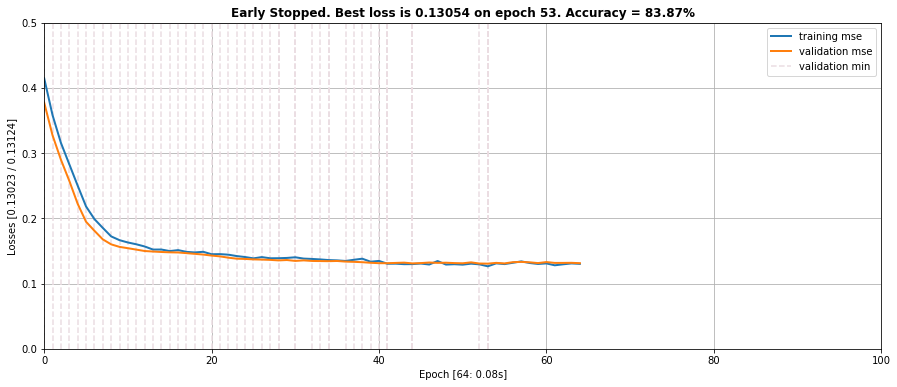

In [9]:
model_name = 'titanic_nn'
fit_params = {
    'model_name': model_name,
    'loss':       'mse',
    'opt':        Adam(), 
    'batch_size': 10, 
    'nepochs':    100,
    'patience':   10,
    'ploss':      0.5,
    'reset':      True,
}

#train_network(titanic_nn, 
#              [trn_pclas, trn_sex, trn_age, trn_sibsp, trn_parch, trn_cabin, trn_title], y_train, 
#              [val_pclas, val_sex, val_age, val_sibsp, val_parch, val_cabin, val_title], y_validate, **fit_params)

train_network(titanic_nn, 
              [trn_pclas, trn_sex, trn_sibsp, trn_parch, trn_title], y_train, 
              [val_pclas, val_sex, val_sibsp, val_parch, val_title], y_validate, **fit_params);

## 8 - Avaliando a rede

In [10]:
#titanic_nn = test_network(model_name, [val_pclas, val_sex, val_age, val_sibsp, val_parch, val_cabin, val_title], y_validate)
titanic_nn = test_network(model_name, [val_pclas, val_sex, val_sibsp, val_parch, val_title], y_validate)

Model from epoch 53
[INFO] evaluating in the test data set ...
128/217 [================>.............] - ETA: 0s
[INFO] acc on the test data set: 0.84 [0.13054]


## 9 - Previsão dos sobreviventes do Titanic

In [11]:
#predict = titanic_nn.predict([tst_pclas, tst_sex, tst_age, tst_sibsp, tst_parch, tst_cabin, tst_title])
predict = titanic_nn.predict([tst_pclas, tst_sex, tst_sibsp, tst_parch, tst_title])
predict = predict.argmax(axis=1)

## 10 - Preparação dos dados para submissão

In [12]:
submission = pd.DataFrame()
submission['PassengerId'] = proc_test_data['PassengerId']
submission['Survived'] = predict

In [13]:
submission.shape

(418, 2)

In [14]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [15]:
submission.to_csv('Titanic-Kaggle.csv', index=False)